In [74]:
import numpy as np
import torch
import torch.nn as nn
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

In [75]:
iris = sns.load_dataset('iris')
data = torch.tensor(iris.drop('species', axis=1).values, dtype=torch.float32)
labels = iris['species'].map({'setosa': 0, 'versicolor': 1, 'virginica': 2}).values
labels = torch.tensor(labels, dtype=torch.long) # torch long is used for classification labels

In [76]:
torch.mean(labels.float())

tensor(1.)

In [77]:
X_train, X_test, y_train, y_test = train_test_split(
    data, labels, 
    test_size=0.2, 
    random_state=26, 
    stratify=labels  # This ensures balanced classes in both sets
)

# Check the distribution of classes in the training and testing sets
torch.mean(y_train.float()), torch.mean(y_test.float())

(tensor(1.), tensor(1.))

In [78]:
# model architecture
ANNiris = nn.Sequential(
    nn.Linear(4, 64), 
    nn.ReLU(),       
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.Linear(64, 3)
)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(ANNiris.parameters(), lr=0.01)

In [79]:
num_epochs = 300

test_accuracies = torch.zeros(num_epochs)
train_accuracies = torch.zeros(num_epochs)

for epoch in range(num_epochs):
    # forward pass
    y_pred_logits_train = ANNiris(X_train) 
    y_pred_logits_test = ANNiris(X_test)
    
    # compute loss
    loss = loss_fn(y_pred_logits_train, y_train)
    
    # compute accuracy
    y_pred_train = torch.argmax(y_pred_logits_train, dim=1) # get the index of the max logit for each sample
    train_accuracies[epoch] = (y_pred_train == y_train).float().mean().item()

    
    y_pred_test = torch.argmax(y_pred_logits_test, dim=1)
    test_accuracies[epoch] = (y_pred_test == y_test).float().mean().item()
    
    # backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# final forward pass to get final predictions
y_pred_logits_train = ANNiris(X_train)
y_pred_logits_test = ANNiris(X_test)
y_pred_train = torch.argmax(y_pred_logits_train, dim=1)
y_pred_test = torch.argmax(y_pred_logits_test, dim=1)
total_accuracy_train = (y_pred_train == y_train).float().mean().item()
total_accuracy_test = (y_pred_test == y_test).float().mean().item()

print(f'Final accuracy on the training data: {total_accuracy_train * 100:.2f}%')
print(f'Final accuracy on the testing data: {total_accuracy_test * 100:.2f}%')
# Sometimes the test set could have better accuracy than the training set due to 
# random initialization and small dataset size, but generally we expect the training
# accuracy to be higher.

Final accuracy on the training data: 95.83%
Final accuracy on the testing data: 93.33%


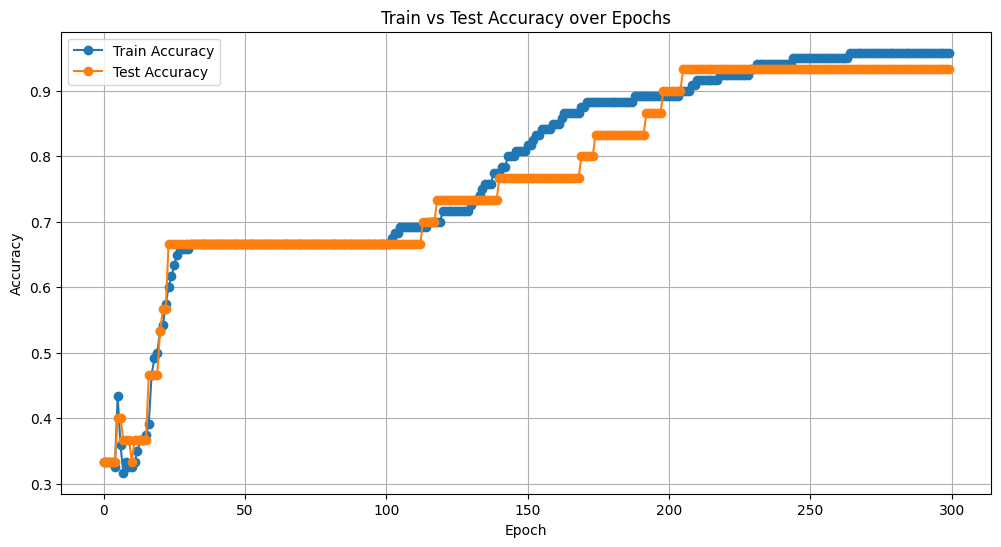

In [80]:
fig = plt.figure(figsize=(12, 6))
plt.plot(train_accuracies.numpy(), label='Train Accuracy', marker='o')
plt.plot(test_accuracies.numpy(), label='Test Accuracy', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train vs Test Accuracy over Epochs')
plt.legend()
plt.grid()
plt.show()

# The reason for the steps in the test accuracy curve is that the model is learning and improving
# its performance on the test set at certain epochs, which leads to sudden jumps in accuracy. This 
# can happen when the model finds a better decision boundary that correctly classifies more samples 
# in the test set. Also having a small dataset like Iris can lead to more noticeable jumps in accuracy
# as the model learns.

In [81]:
# DataLoaders are a PyTorch utility that provides an efficient way to iterate over datasets in batches, 
# shuffle data, and load data in parallel using multiprocessing workers. They are particularly useful 
# for training models on large datasets that cannot fit into memory all at once. By using DataLoaders, 
# you can easily manage the training process, improve performance, and reduce memory usage.

# we need to put together the features and labels into a dataset object that the DataLoader can use
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

# this creates an iterator that will yield batches of 12 samples, 
# and it will shuffle the data at the beginning of each epoch to help with generalization.
train_loader = DataLoader(train_dataset, batch_size=12, shuffle=True) 

# sometimes the data is so big that we can't even load the test set
# in this case, since the test set is small, we can load it all at once
num_samples_test = test_dataset.tensors[0].shape[0] # number of samples in the test set
test_loader = DataLoader(test_dataset, batch_size=num_samples_test, shuffle=False) # no need to shuffle test data

In [82]:
def createANN():
    model = nn.Sequential(
        nn.Linear(4, 64), 
        nn.ReLU(),       
        nn.Linear(64, 64),
        nn.ReLU(),
        nn.Linear(64, 3)
    )

    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

    return model, loss_fn, optimizer

def train_model(model, loss_fn, optimizer, train_loader, test_loader, num_epochs=300):
    train_accuracies = torch.zeros(num_epochs)
    test_accuracies = torch.zeros(num_epochs)

    for epoch in range(num_epochs):
        batch_accuracies = []
        for X_batch, y_batch in train_loader:

            # forward pass 
            y_pred_logits = model(X_batch)
            loss = loss_fn(y_pred_logits, y_batch)

            # compute accuracy for the batch
            y_pred_labels = torch.argmax(y_pred_logits, dim=1)
            batch_accuracy = (y_pred_labels == y_batch).float().mean().item()
            batch_accuracies.append(batch_accuracy)

            # backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # average accuracy for the epoch
        train_accuracies[epoch] = np.mean(batch_accuracies)

        # evaluate on the test set
        for X_test_batch, y_test_batch in test_loader: # in this case it will be only one batch
            y_test_pred_logits = model(X_test_batch)
            y_test_pred_labels = torch.argmax(y_test_pred_logits, dim=1)
            test_accuracies[epoch] = (y_test_pred_labels == y_test_batch).float().mean().item()

    return train_accuracies, test_accuracies

In [83]:
num_epochs = 500

model, loss_fn, optimizer = createANN()
train_accuracies, test_accuracies = train_model(model, loss_fn, optimizer, train_loader, test_loader, num_epochs)

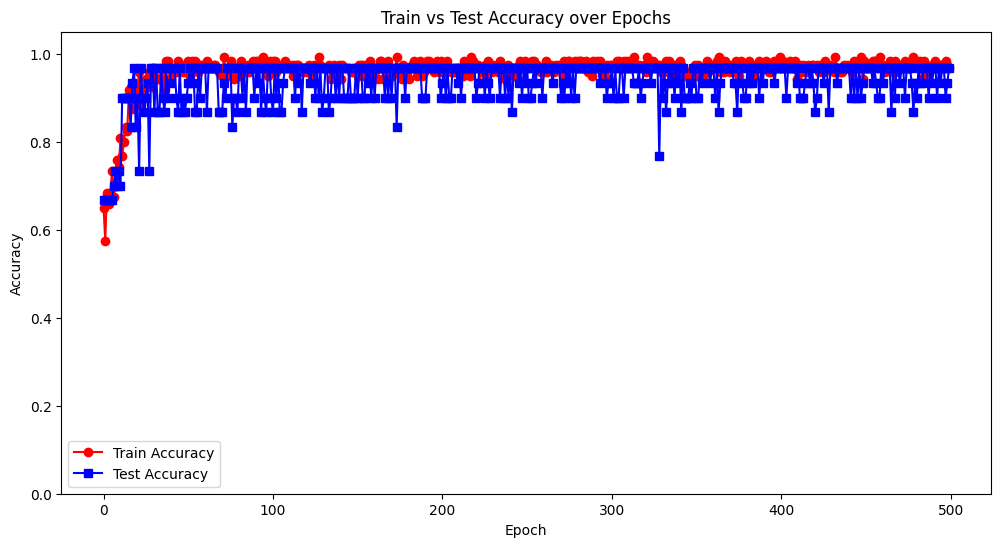

In [ ]:
fig = plt.figure(figsize=(12, 6))
plt.plot(train_accuracies.numpy(), "ro-", label='Train Accuracy')
plt.plot(test_accuracies.numpy(), "bs-", label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train vs Test Accuracy over Epochs')
plt.ylim(0, 1.05) # set y-axis limits to better visualize accuracy
plt.legend()
plt.show()

# We can see that compared with training with one batc, applying mini-batch training 
# leads to a smoother accuracy curve, which is more stable and less noisy. And in addition
# it reaches a ~90% with only 50 epochs, while the previous ones took 300 epochs to reach a similar accuracy.

In [ ]:
# to create a dev set, we can create a temportal split and then divided by two
# therefore we will have 80-10-10 split for train-dev-test
X_train, X_temp, y_train, y_temp = train_test_split(
    data, labels, test_size=0.20, random_state=42, stratify=labels  # This ensures balanced classes in both sets
)

# Step 2: Split the 20% temporary set into Dev and Test (50% each of 20% = 10% total)
X_dev, X_test, y_dev, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp  # This ensures balanced classes in both sets
)

In [ ]:
# for regression, normally the stratication is not as important, but the way of doing it is:

# 1. Create 5 bins based on the target variable 'y'
# This labels each row as being in the 1st, 2nd, 3rd... 5th quintile
import pandas as pd
y_bins = pd.qcut(labels, q=5, labels=False)

# 2. Split using these bins as the stratification target
X_train, X_test, y_train, y_test = train_test_split(
    data, labels, test_size=0.2, stratify=y_bins, random_state=42
)